### Importing Required Libraries

In [1]:
import pandas as pd
import urllib, os, pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn import compose
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import NearMiss

# Models
import xgboost
import catboost  
import lightgbm  
from sklearn import tree
from sklearn import linear_model 
from sklearn import svm 
from sklearn import neighbors 
from sklearn import ensemble 
from sklearn.dummy import DummyRegressor
from sklearn.base import clone
from sklearn.utils import all_estimators
# Setup reproductibility
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

### Loading/Reading the dataset

In [2]:
train_df= pd.read_csv('Data/train.csv')
test_df= pd.read_csv('Data/test.csv')
merged = [train_df, test_df]
gender_submission= pd.read_csv('Data/gender_submission.csv')

In [3]:
# Viewing train dataset
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Viewing test dataset
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Exploring the dataset

In [5]:
# Checking the shape of the train data(number of rows and columns)
train_df.shape

(891, 12)

In [6]:
# Checking the shape of the test data(number of rows and columns)
test_df.shape

(418, 11)

In [7]:
# checking the number of unique values in each column of the data
train_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [8]:
# Checking the completness of the data, and data types of each column
train_df.info()
print('---------------------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

### Data Types
The data consist of 891 rows and 12 columns. Each row represents the data of a unique passenger. We have one target column (Survived) and the remaining 11 columns contains features of each passenger.

### Categorical Features EDA

In this section, we will visualise each categorical variable in the data separately by visualising the:

- Percentage Composition of the unique values in each variable
- Distribution of the unique values in each variable by Survival
- Violin plot for each variable by [Fare]


In [9]:
# Functions for Categorical Features EDA

def pclass(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.Pclass.value_counts(), labels = ['Pclass 3', 'Pclass 1', 'Pclass 2'], autopct = '%.1f%%',
            radius = 1, textprops = {'fontsize':22, 'fontweight':'bold'})
    plt.title('Passenger Ticket Class Composition', fontweight = 'bold', fontsize = 30)
    
    plt.subplot(132)
    a = sns.countplot(data = df, x = 'Pclass', hue = 'Survived')
    a.set_title('Passenger Ticket Class Distribution by Survival', fontsize = 30, fontweight = 'bold')
    a.set_xlabel('Pclass', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('Count', fontweight = 'bold', fontsize = 22)
    
    plt.subplot(133)
    x = sns.violinplot('Pclass', 'Fare', 'Survived', df, split = True)
    x.set_title('Violin Plot for Passenger Ticket Class by Fare', fontsize = 30, fontweight = 'bold')
    x.set_xlabel('Pclass', fontsize = 22, fontweight = 'bold')
    x.set_ylabel('Fare', fontweight = 'bold', fontsize = 22)
    
    plt.tight_layout()
    
def sex(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.Sex.value_counts(), labels = ['Male', 'Female'], autopct = '%.1f%%',
            radius = 1, textprops = {'fontsize':22, 'fontweight':'bold'})
    plt.title('Passenger Sex Composition', fontweight = 'bold', fontsize = 30)
    
    plt.subplot(132)
    a = sns.countplot(data = df, x = 'Sex', hue = 'Survived')
    a.set_title('Sex Distribution by Survival', fontsize = 30, fontweight = 'bold')
    a.set_xlabel('Sex', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('Count', fontweight = 'bold', fontsize = 22)
    
    plt.subplot(133)
    x = sns.violinplot('Sex', 'Fare', 'Survived', df, split = True)
    x.set_title('Violin Plot for Sex by Fare', fontsize = 30, fontweight = 'bold')
    x.set_xlabel('Sex', fontsize = 22, fontweight = 'bold')
    x.set_ylabel('Fare', fontweight = 'bold', fontsize = 22)
    
def sibsp(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.SibSp.value_counts(), labels = ['0','1', '2', '3', '4','5','8'], autopct = '%.1f%%',
            radius = 1, textprops = {'fontsize':20})
    plt.title('# of siblings/spouses Composition', fontweight = 'bold', fontsize = 30)
    
    plt.subplot(132)
    a = sns.countplot(data = df, x = 'SibSp', hue = 'Survived')
    a.set_title('SibSp Distribution by Survival', fontsize = 30, fontweight = 'bold')
    a.set_xlabel('SibSp', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('Count', fontweight = 'bold', fontsize = 22)
    a.legend(loc='upper right', title='Survived')
    
    plt.subplot(133)
    x = sns.violinplot('SibSp', 'Fare', 'Survived', df, split = True)
    x.set_title('Violin Plot for SibSp by Fare', fontsize = 30, fontweight = 'bold')
    x.set_xlabel('SibSp', fontsize = 22, fontweight = 'bold')
    x.set_ylabel('Fare', fontweight = 'bold', fontsize = 22)
    
def parch(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.Parch.value_counts(),labels = ['0','1', '2', '3', '4','5','6'], autopct = '%.1f%%',
            radius = 1, textprops = {'fontsize':20})
    plt.title('# of parents/children Composition', fontweight = 'bold', fontsize = 30)
    
    plt.subplot(132)
    a = sns.countplot(data = df, x = 'Parch', hue = 'Survived')
    a.set_title('Parch Distribution by Survival', fontsize = 30, fontweight = 'bold')
    a.set_xlabel('Parch', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('Count', fontweight = 'bold', fontsize = 22)
    a.legend(loc='upper right', title='Survived')
    
    plt.subplot(133)
    x = sns.violinplot('Parch', 'Fare', 'Survived', df, split = True)
    x.set_title('Violin Plot for Parch by Fare', fontsize = 30, fontweight = 'bold')
    x.set_xlabel('Parch', fontsize = 22, fontweight = 'bold')
    x.set_ylabel('Fare', fontweight = 'bold', fontsize = 22)
    
def embarked(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.Embarked.value_counts(),labels = ['Southampton(S)', 'Cherbourg(C)', 'Queenstown(Q)'], autopct = '%.1f%%',
            radius = 1, textprops = {'fontsize':20})
    plt.title('Passenger Port of Embarkation Composition', fontweight = 'bold', fontsize = 30)
    
    plt.subplot(132)
    a = sns.countplot(data = df, x = 'Embarked', hue = 'Survived')
    a.set_title('Embarked Distribution by Survival', fontsize = 30, fontweight = 'bold')
    a.set_xlabel('Embarked', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('Count', fontweight = 'bold', fontsize = 22)
    
    plt.subplot(133)
    x = sns.violinplot('Embarked', 'Fare', 'Survived', df, split = True)
    x.set_title('Violin Plot for Embarked by Fare', fontsize = 30, fontweight = 'bold')
    x.set_xlabel('Embarked', fontsize = 22, fontweight = 'bold')
    x.set_ylabel('Fare', fontweight = 'bold', fontsize = 22)

#### Ticket class

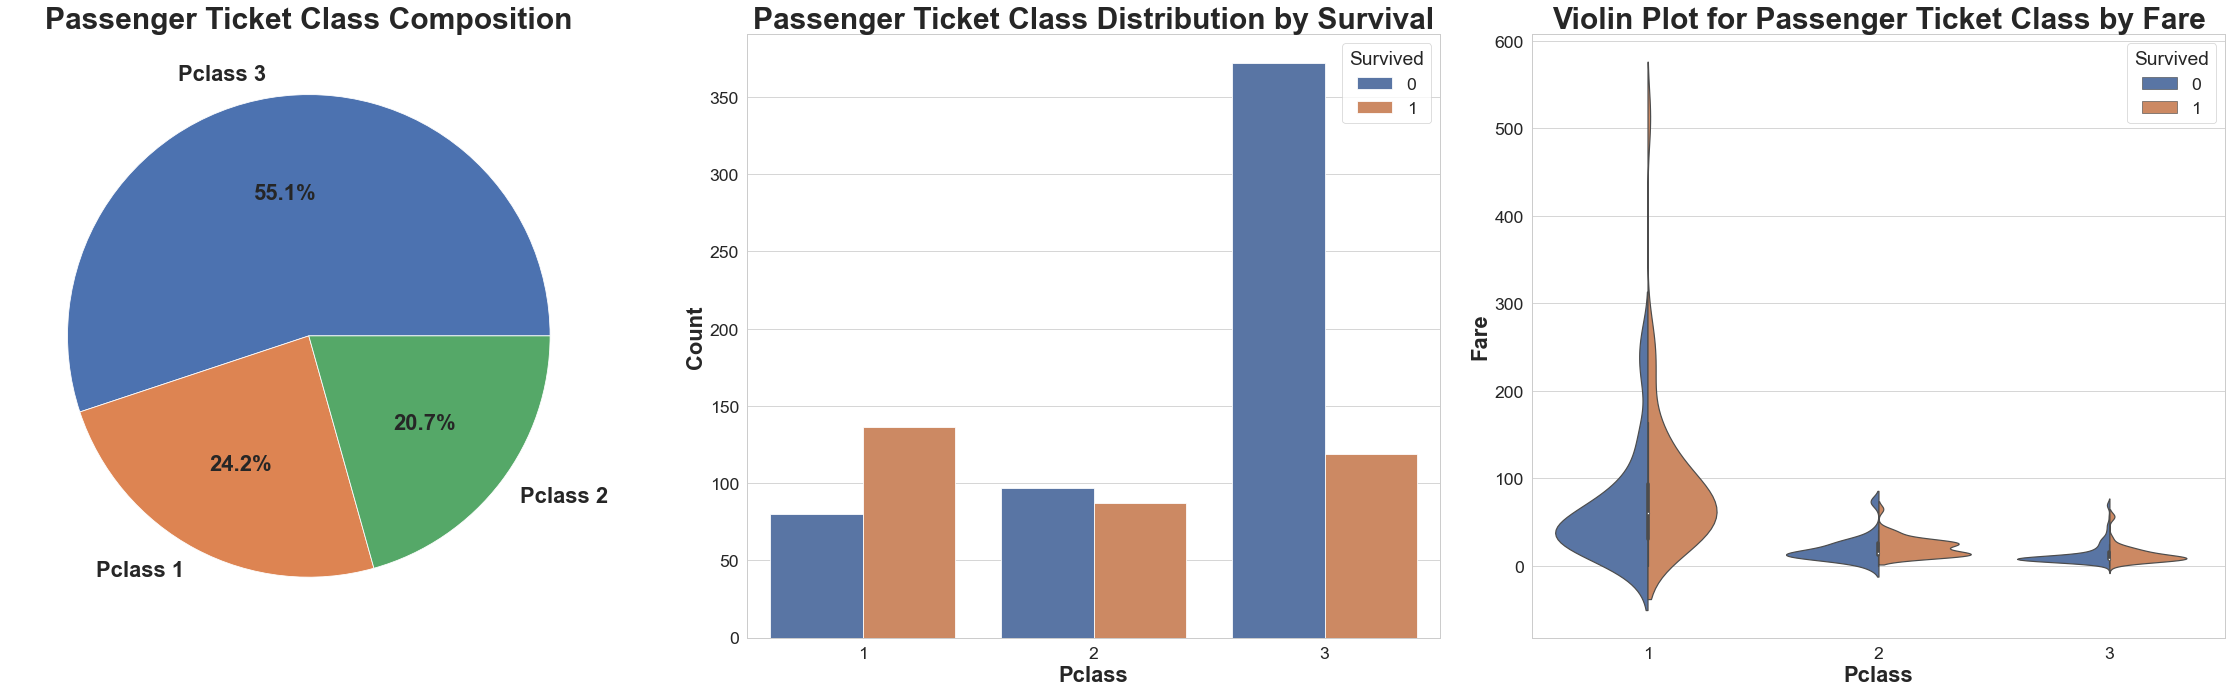

In [10]:
pclass(train_df)

**Comments:**
- Over 50% of the total number of passengers onboard were on 3rd Class Ticket.
- Overall, passengers on 1st class ticket survived more than others. Though more passengers on 3rd class survived than 2nd class, a higher proportion of passengers on 2nd class survvived than those on 3rd class.
- Overall, Passengers who paid higher fare tend to survived more than others.

#### Sex

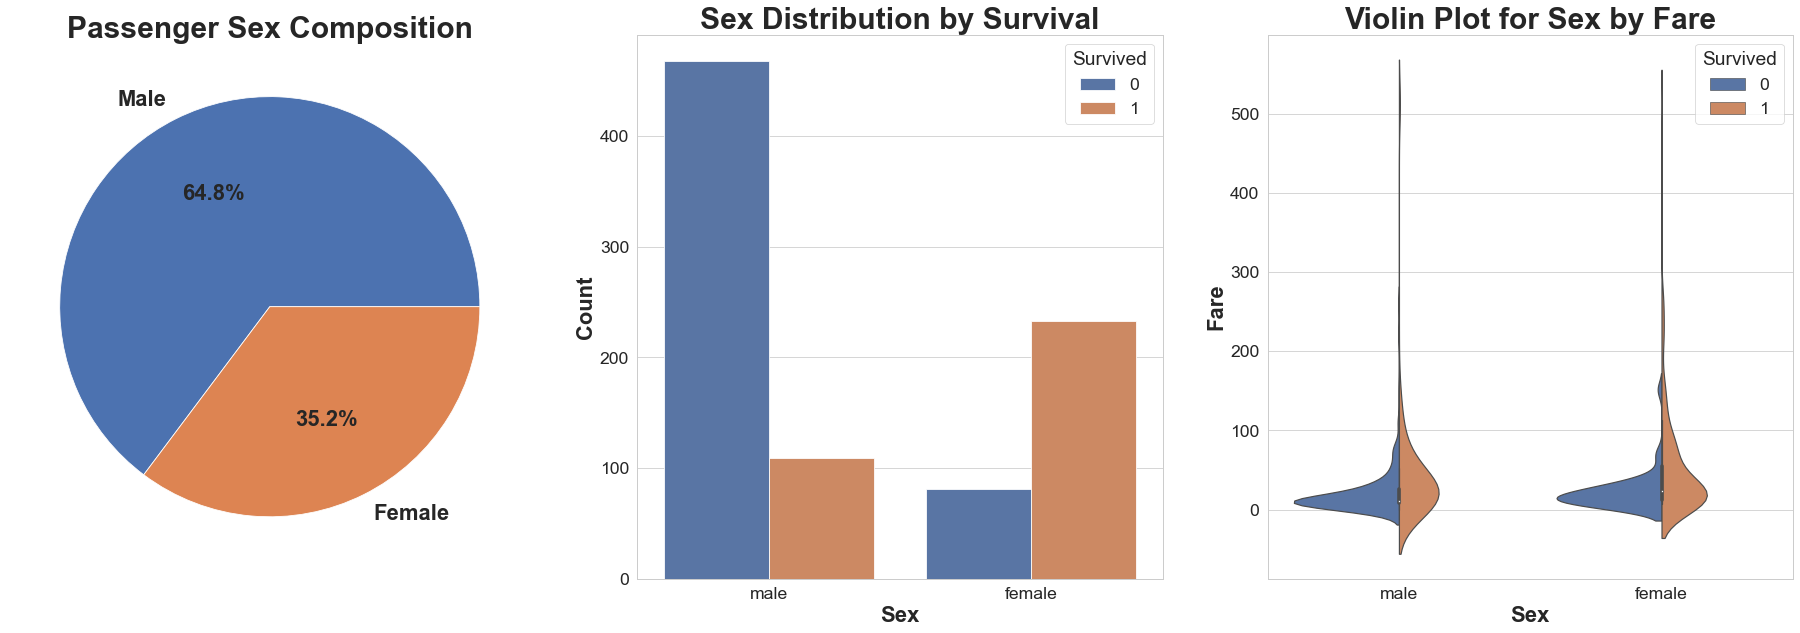

In [11]:
sex(train_df)

**Comments:**
- About 64.8% of the passengers onboard were Males
- A significantly higher proportion of Females survived than Males

#### # of siblings / spouses aboard the Titanic (SibSp)

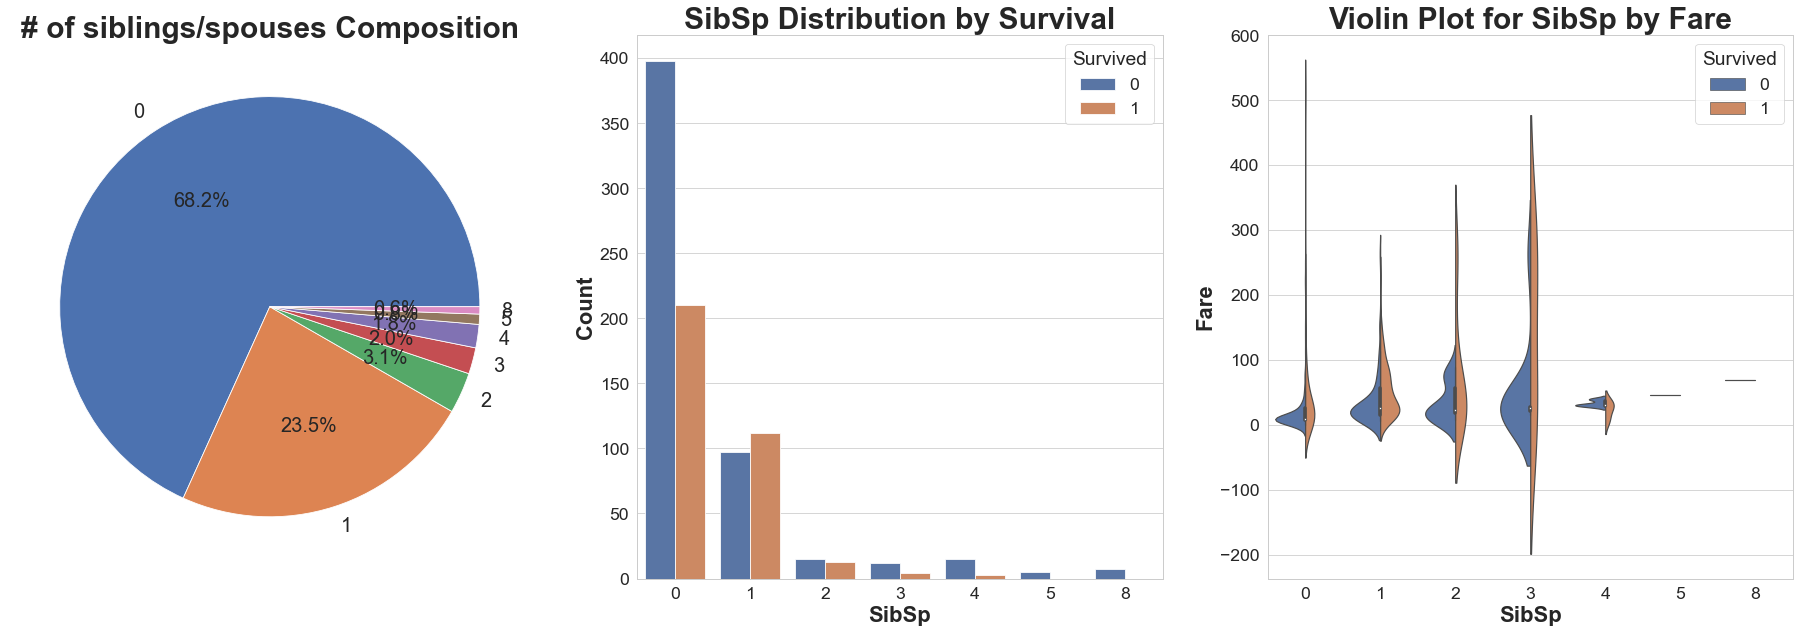

In [12]:
sibsp(train_df)

**Comments:**
- About 68.2% of passengers onboard had no siblings or spouses with them on the train
- A significant proportion of passengers with 1 or 2 sibling/spouse survived than others.

#### # of parents / children aboard the Titanic(Parch)

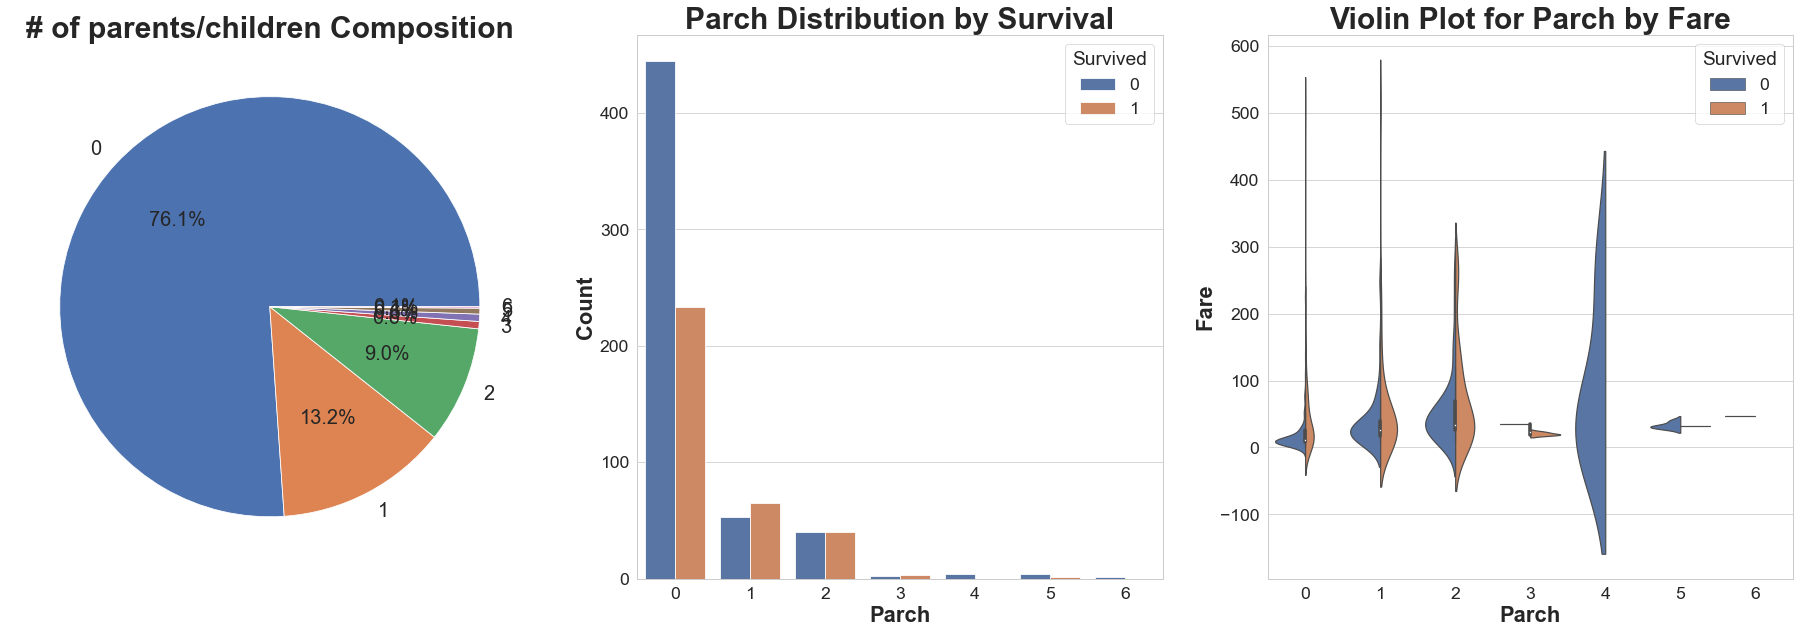

In [13]:
parch(train_df)

**Comments:**
- About 76.1% of passengers onboard had no parents/children relationship
- Proprtion wise, passengers with 1 to 3 parents/children relationship survied more than others

#### Port of Embarkation (Embarked)

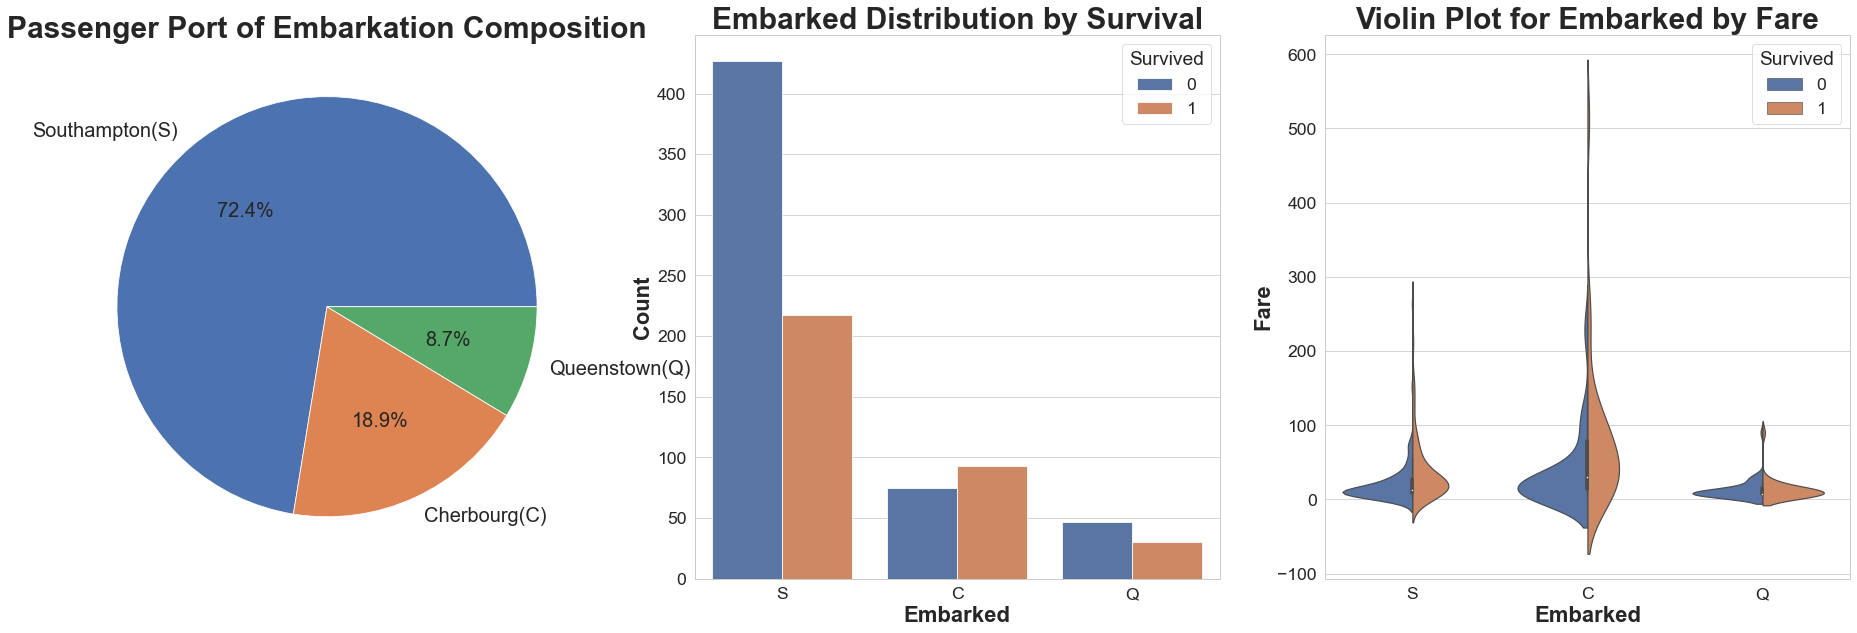

In [14]:
embarked(train_df)

**Comments:**
- About 72.4% of passengers boarded the ship from Southampton
- Although a higher number of passengers that survived boarded the ship from Southampton, a significantly higher proportion of passengers who survived boarded the ship from Cherbourg

### Numerical Feature EDA

In [15]:
def kde_plot(df, feature):
    plt.figure(figsize = (12, 5))
    plt.title(f"Kernel Density Estimation for Passenger {feature}", fontsize = 30, fontweight = 'bold')
    ax = sns.kdeplot(df[df.Survived == 0][feature].dropna(), label = 'Not Survived', lw = 2, legend = True)
    ax1 = sns.kdeplot(df[df.Survived == 1][feature].dropna(), label = 'Survived', lw = 2, legend = True)
    plt.xlabel('Passenger fare', fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

#### KDE Plot for Passenger Fare

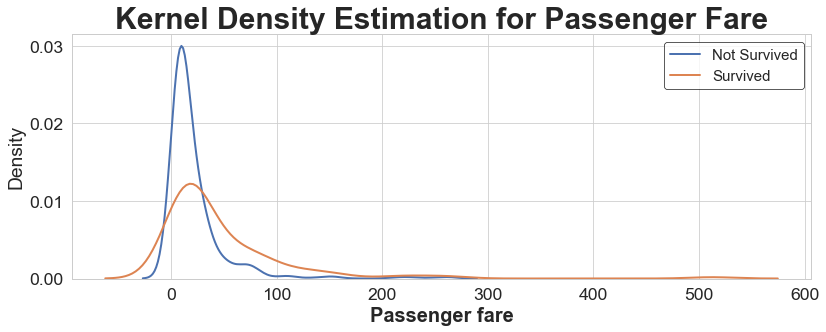

In [16]:
kde_plot(train_df, 'Fare')

**Comments:**
- The chances of passengers surviving tends to increase with higher fares

### **Feature Engineering**

In [17]:
# Checking the shape of the dataset(Before and After dropping irrelevant columns)

print("Before", train_df.shape, test_df.shape, merged[0].shape, merged[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin', 'Name'], axis=1)
merged = [train_df, test_df]

print("After", train_df.shape, test_df.shape, merged[0].shape, merged[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 8) (418, 8) (891, 8) (418, 8)


In [18]:
# Creating a column for family size using [Parch] and [SibSp]
for dataset in merged:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [19]:
# Creating a column [IsAlone] with family size column(To differentiate passengers with no relatives from others)
for dataset in merged:
    dataset['IsAlone'] = 'No'
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 'Yes'

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,No,0.505650
1,Yes,0.303538


In [20]:
# Dropping columns that will not be needed
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
merged = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,male,22.0,7.2500,S,No
1,1,1,female,38.0,71.2833,C,No
2,1,3,female,26.0,7.9250,S,Yes
3,1,1,female,35.0,53.1000,S,No
4,0,3,male,35.0,8.0500,S,Yes


In [21]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,892,3,male,34.5,7.8292,Q,Yes
1,893,3,female,47.0,7.0000,S,No
2,894,2,male,62.0,9.6875,Q,Yes
3,895,3,male,27.0,8.6625,S,Yes
4,896,3,female,22.0,12.2875,S,No


In [22]:
# Converting Pclass into categorical features
for dataset in merged:
    dataset['Pclass'].replace(1, '1st', inplace = True)
    dataset['Pclass'].replace(2, '2nd', inplace = True)
    dataset['Pclass'].replace(3, '3rd', inplace = True)

In [23]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3rd,male,22.0,7.2500,S,No
1,1,1st,female,38.0,71.2833,C,No
2,1,3rd,female,26.0,7.9250,S,Yes
3,1,1st,female,35.0,53.1000,S,No
4,0,3rd,male,35.0,8.0500,S,Yes


In [24]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,892,3rd,male,34.5,7.8292,Q,Yes
1,893,3rd,female,47.0,7.0000,S,No
2,894,2nd,male,62.0,9.6875,Q,Yes
3,895,3rd,male,27.0,8.6625,S,Yes
4,896,3rd,female,22.0,12.2875,S,No


In [25]:
target_col = train_df['Survived']
train_df = train_df.drop(columns = ['Survived'])

In [26]:
# for percent [0; 100] of nan in dataframe
features = train_df.columns
missing_threshold = 50
check = (train_df[features].isna().sum() / ((train_df.shape[0]) / 100))

valid_features = check[check < missing_threshold].index.to_list()
check.sort_values(ascending=False)

Age         19.865320
Embarked     0.224467
Pclass       0.000000
Sex          0.000000
Fare         0.000000
IsAlone      0.000000
dtype: float64

In [27]:
train_df[valid_features].infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    object 
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   Fare      891 non-null    float64
 4   Embarked  889 non-null    object 
 5   IsAlone   891 non-null    object 
dtypes: float64(2), object(4)
memory usage: 41.9+ KB


In [28]:
num_cols = train_df[valid_features].select_dtypes(include=np.number).columns.tolist()
cat_cols = train_df[valid_features].select_dtypes(exclude=np.number).columns.tolist()

print( f"Numeric features : {len(num_cols)}" )
print( f"Categorical features : {len(cat_cols)}" )

Numeric features : 2
Categorical features : 4


#### Splitting Train dataset

In [29]:
X = train_df[valid_features]
y = target_col

X_test_ = test_df[valid_features]

X_train_, X_eval_, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0)
(X_train_.shape, y_train.shape) , (X_eval_.shape, y_eval.shape), (X_test_.shape)

(((712, 6), (712,)), ((179, 6), (179,)), (418, 6))

#### Normalization and Encoding the dataset

In [30]:
# Pipeline for the Numeric features 
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

# Pipeline for the Categorical features
encoder_categories = [train_df[cat_cols[i] ].append(test_df[cat_cols[i] ] ).dropna().unique() for i in range(len(cat_cols)) ]

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", preprocessing.OneHotEncoder(categories=encoder_categories, drop="first", sparse=False)) #if_binary
           ])

# Associate the two pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)
X_train__, X_eval__, X_test__ = preprocessor.fit_transform(X_train_), preprocessor.transform(X_eval_), preprocessor.transform(X_test_)

# New categorical feature names
feature_names_out = preprocessor.named_transformers_['cat'][-1].get_feature_names_out().tolist()
indexes = [ int(feature_names_out[i][1:feature_names_out[i].find("_")]) for i in range(len(feature_names_out))]
cat_cols_encoded = [  col.replace( f"x{i}", cat_cols[i] )  for col,i in zip(feature_names_out, indexes)]
print( f"Categorical features after encoding : {len(cat_cols_encoded)}" )

# train df
df_X_train = pd.DataFrame(X_train__, columns=num_cols+cat_cols_encoded)

# eval df
df_X_eval = pd.DataFrame(X_eval__, columns=num_cols+cat_cols_encoded)

# test df
df_X_test = pd.DataFrame(X_test__, columns=num_cols+cat_cols_encoded)

Categorical features after encoding : 6


In [31]:
df_X_train.head()

,Age,Fare,Pclass_1st,Pclass_2nd,Sex_female,Embarked_C,Embarked_Q,IsAlone_Yes
0,-0.045676,-0.331679,0.0,0.0,1.0,1.0,0.0,0.0
1,0.107186,-0.426405,0.0,1.0,0.0,0.0,0.0,1.0
2,0.107186,0.102620,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.733559,-0.555896,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.657127,-0.491276,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
df_X_eval.head()

,Age,Fare,Pclass_1st,Pclass_2nd,Sex_female,Embarked_C,Embarked_Q,IsAlone_Yes
0,-0.045676,-0.347398,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.045676,-0.485288,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.727166,-0.054650,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.045676,2.288576,1.0,0.0,1.0,1.0,0.0,0.0
4,-0.045676,-0.331679,0.0,0.0,1.0,1.0,0.0,0.0


In [33]:
df_X_test.head()

,Age,Fare,Pclass_1st,Pclass_2nd,Sex_female,Embarked_C,Embarked_Q,IsAlone_Yes
0,0.374696,-0.479715,0.0,0.0,0.0,0.0,1.0,1.0
1,1.330088,-0.496266,0.0,0.0,1.0,0.0,0.0,0.0
2,2.476559,-0.442623,0.0,1.0,0.0,0.0,1.0,1.0
3,-0.198539,-0.463082,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.580696,-0.390727,0.0,0.0,1.0,0.0,0.0,0.0


### Model Training

- We are going to train multiple models using pipelines and compare them

In [34]:
estimator_type = 'classifier'   
estimators = all_estimators(type_filter=estimator_type)
random_state = 0

all_models = []
for name, EstimatorClass in estimators:
    try:
        if "CV" in name or "IC" in name or "Isotonic" in name or "Elastic" in name: continue
        if 'random_state' in EstimatorClass().get_params().keys():
            model = EstimatorClass(random_state=random_state)
        else:
            model = EstimatorClass()

        all_models.append(model)
        # print('Appending', name)
    except Exception as e:
        pass
        # print('Unable to import', name)
        # print(e)

print(f"[Info] Estimators of type '{estimator_type}' loaded: {len(all_models)}" )

[Info] Estimators of type 'classifier' loaded: 31


In [35]:
# preprocessor for the raw features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)

# end 2 end pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("estimator", None)]
)
# Grid search parameters
param_grid_ = {
    'estimator': all_models[:31], 
}

# SearchCV
end2end_grid_search = GridSearchCV(pipe, param_grid_, cv=3, scoring="neg_mean_absolute_error", refit=True, n_jobs=-1)

In [36]:
end2end_grid_search = end2end_grid_search.fit(X, y)

In [37]:
end2end_grid_search.best_params_

{'estimator': GradientBoostingClassifier(random_state=0)}

In [38]:
cv_results = end2end_grid_search.cv_results_

# pick out the best results
# =========================
scores_df = pd.DataFrame(cv_results)
scores_df_sorted = scores_df.sort_values(by='rank_test_score')
scores_df_sorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,0.159542,0.006506,0.010419,0.007367,GradientBoostingClassifier(random_state=0),{'estimator': GradientBoostingClassifier(rando...,-0.188552,-0.178451,-0.181818,-0.182941,0.004199,1
12,0.365645,0.003107,0.021176,0.007145,HistGradientBoostingClassifier(random_state=0),{'estimator': HistGradientBoostingClassifier(r...,-0.212121,-0.202020,-0.175084,-0.196409,0.015632,2
30,0.037852,0.006931,0.026620,0.005410,SVC(random_state=0),{'estimator': SVC(random_state=0)},-0.208754,-0.208754,-0.175084,-0.197531,0.015872,3
19,0.765498,0.007179,0.006366,0.009003,MLPClassifier(random_state=0),{'estimator': MLPClassifier(random_state=0)},-0.212121,-0.198653,-0.195286,-0.202020,0.007274,4
0,0.156251,0.001178,0.023473,0.009329,AdaBoostClassifier(random_state=0),{'estimator': AdaBoostClassifier(random_state=0)},-0.225589,-0.212121,-0.178451,-0.205387,0.019824,5
14,0.039931,0.006360,0.017435,0.002025,LabelPropagation(),{'estimator': LabelPropagation()},-0.249158,-0.188552,-0.191919,-0.209877,0.027810,6
15,0.035355,0.005797,0.010416,0.007365,LabelSpreading(),{'estimator': LabelSpreading()},-0.252525,-0.188552,-0.191919,-0.210999,0.029396,7
22,0.041981,0.005236,0.026348,0.005240,NuSVC(random_state=0),{'estimator': NuSVC(random_state=0)},-0.215488,-0.225589,-0.191919,-0.210999,0.014108,7
10,0.350089,0.026686,0.015805,0.000243,GaussianProcessClassifier(random_state=0),{'estimator': GaussianProcessClassifier(random...,-0.249158,-0.198653,-0.185185,-0.210999,0.027537,7
27,0.290547,0.011050,0.034594,0.004022,RandomForestClassifier(random_state=0),{'estimator': RandomForestClassifier(random_st...,-0.249158,-0.188552,-0.205387,-0.214366,0.025544,10


### Applying the optimized model on the test dataset provided by Kaggle

In [39]:
test_pred = end2end_grid_search.predict(X_test_)

### Getting the same prediction format as the sample_submission file

In [40]:
gender_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


<AxesSubplot:>

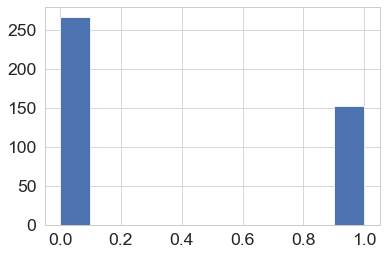

In [41]:
gender_submission.Survived.hist()

<AxesSubplot:>

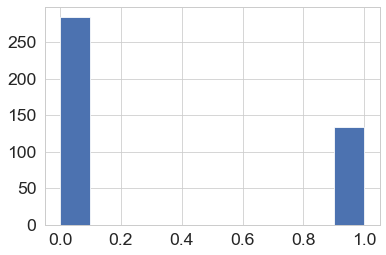

In [42]:
gender_submission['Survived'] = test_pred
gender_submission.Survived.hist()

#### Processing prediction file to Submit to Kaggle site

In [43]:
gender_submission.to_csv("first_sub.csv", index=False)